# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
Goal of this project is to detect lane lines in images or videos of roads. The detected lane lines should be marked in color in a copy of the original image or video.

The following techniques are used:
* Grayscaling
* Gaussian Smoothing
* Canny Edge Detection
* Region of Interest Filtering
* Hough Transform Line Detection


## Import Packages

In [56]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os, glob
import numpy as np
import math
%matplotlib inline

## Test Images

The lane line detection should work well with the following test images, located in the directory `test_images`.

In [57]:
# helper function to display a serias of images arranged in two columns
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images) + 1) // cols

    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

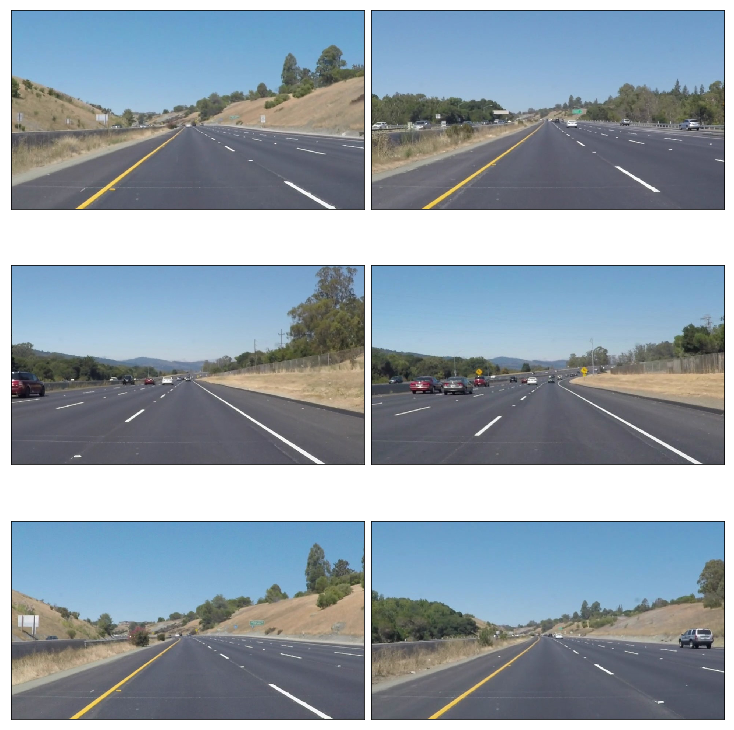

In [58]:
test_image_paths  =  [path for path in glob.glob('test_images/*.jpg')]
test_images       =  [plt.imread(path) for path in test_image_paths]
show_images(test_images)

## Build a Lane Detection Pipeline

### 1. Step: Grayscaling
First the images are converted into grayscale images, because we don't need colors for edge detection and it's easier to handle graysacle images with only one dimension instead of color images with three dimensions.

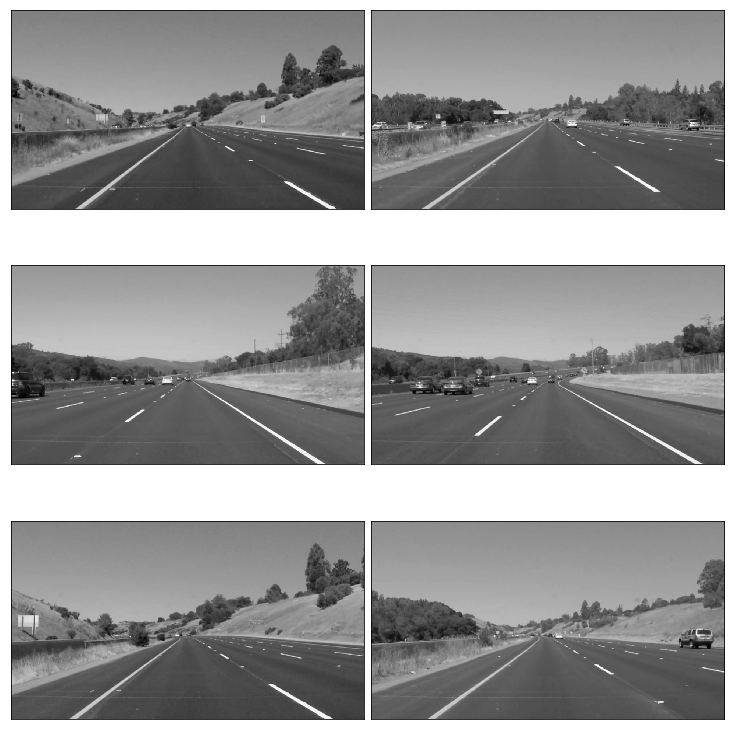

In [59]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, test_images))
show_images(gray_images)

### 2. Step: Gaussian Smooting
The kernal size of the Gaussian filter: The smoothing filter used in the first stage directly affects the results of the Canny algorithm. Smaller filters cause less blurring, and allow detection of small, sharp lines. A larger filter causes more blurring, smearing out the value of a given pixel over a larger area of the image. Larger blurring radii are more useful for detecting larger, smoother edges.

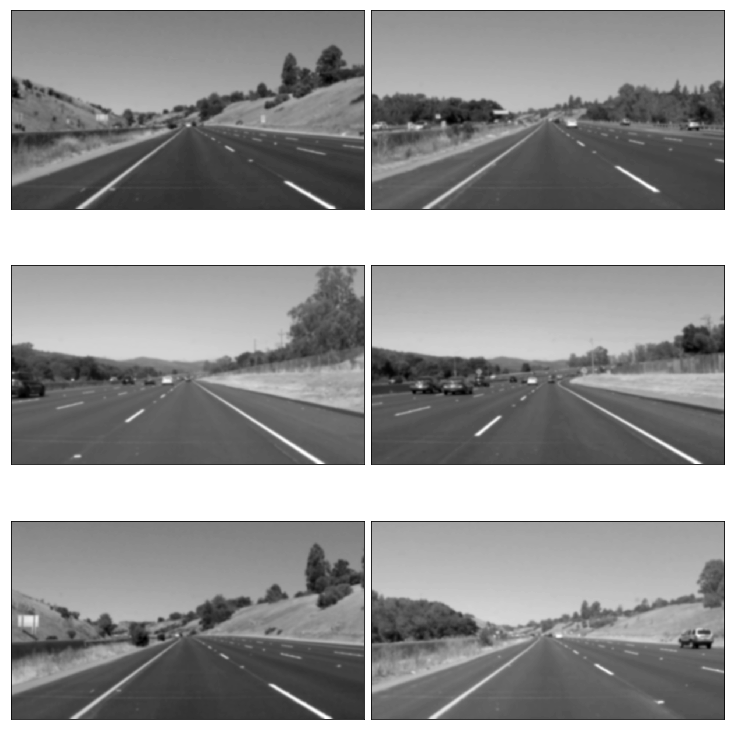

In [60]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))
show_images(blurred_images)

### 3. Step: Canny Edge Detection
Next we use the Canny Edge Detection algorithm to detect edges in our test images.

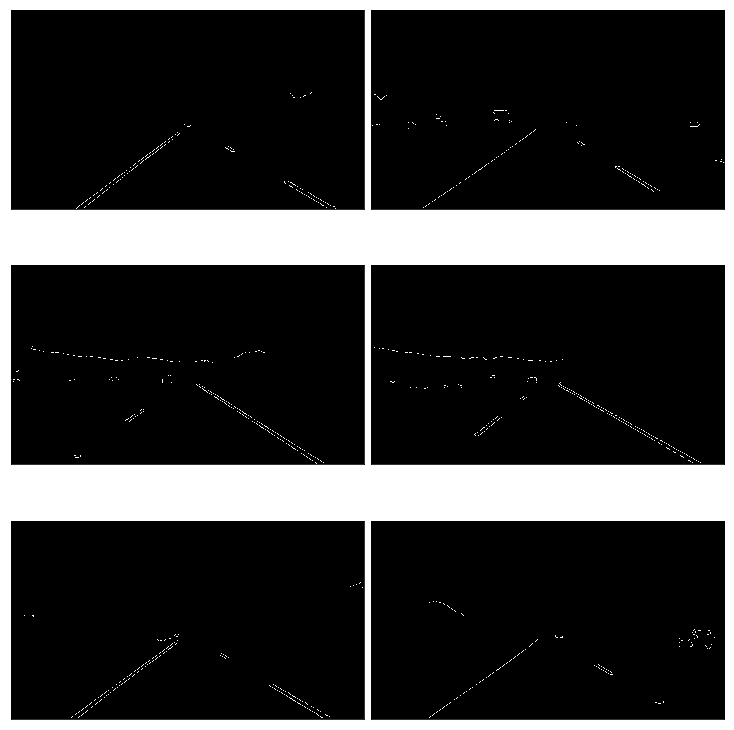

In [61]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))
show_images(edge_images)

### 4. Step: Region of Interest Filtering
Assuming that the camera is centered on the front of the car, the road we want to detect in the image is in a triangular area, from the points at the bottom left, to about the center of the image and bottom right. All other areas of the image are not of interest, and therefore we mask out them in black. 

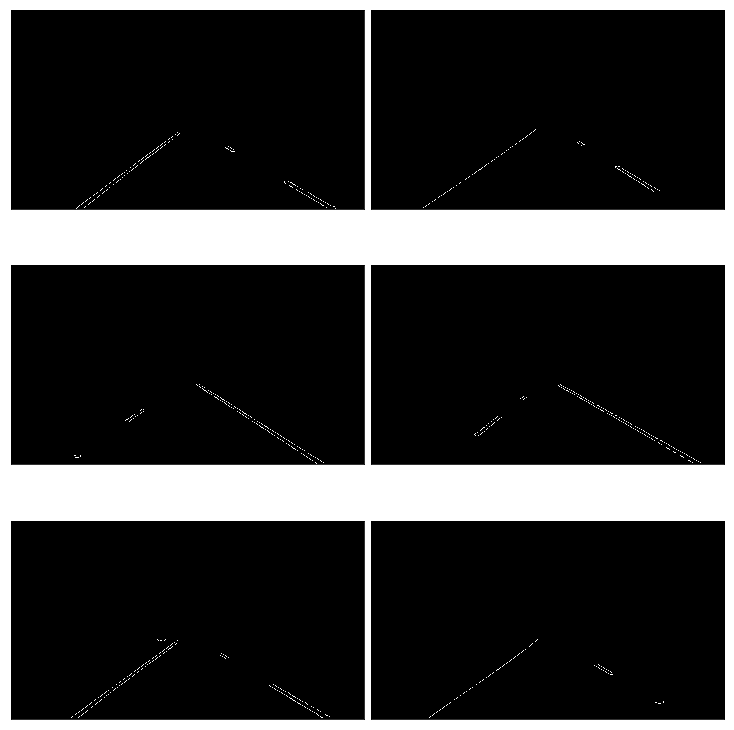

In [62]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,) * mask.shape[2])  # in case, the input image has a channel dimension
    return cv2.bitwise_and(image, mask)

def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols   = image.shape[:2]
    bottom_left  = [0, rows]
    bottom_right = [cols, rows]
    top_left     = [cols * 0.4, rows * 0.6]
    top_right    = [cols * 0.6, rows * 0.6]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

# images showing the region of interest only
roi_images = list(map(select_region, edge_images))
show_images(roi_images)

### 5. Step: Hough Transform Line Detection
The Canny Edge Detection returned many edges, but we want lines. Hough Line Transform helps us to transform the edges into lines.

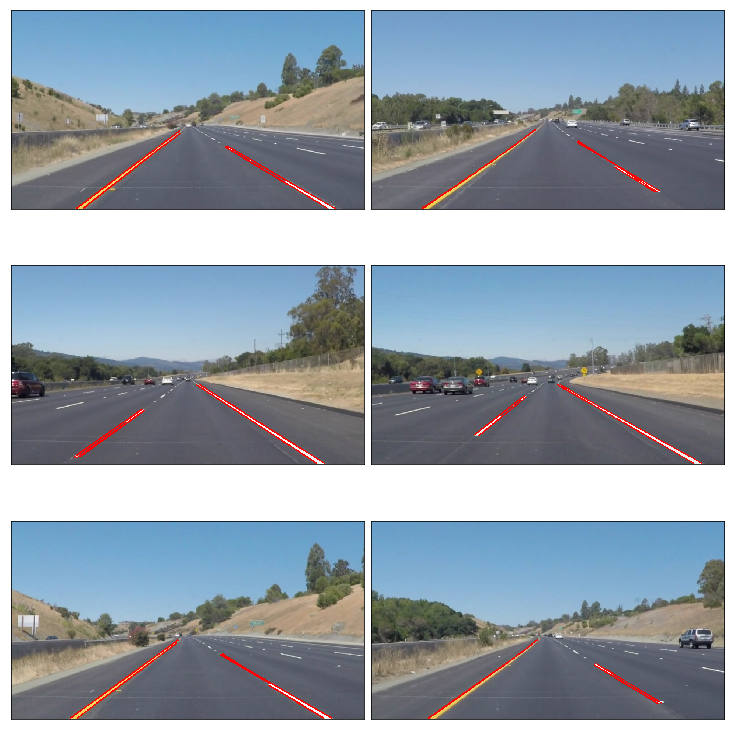

In [63]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi / 180, threshold=20, minLineLength=20, maxLineGap=300)

def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image)  # don't want to modify the original
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

list_of_lines = list(map(hough_lines, roi_images))
line_images = []

for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))

show_images(line_images)

### 6. Step: Calculate Lane Lines
The Hough Line Transformation returned many lines with different slope, intercept and length. But we want to detect only two line lanes, the right and the left one. The idea is to first split all lines into rigtht lines and left lines by their slope. Then we can build the average of the right and left lines, the two averages corresponds to the right and left lane line. Finally we extrapolate the detected line lanes from the bottom of the image to the top of the region of interest, to get two line lanes with equal length.

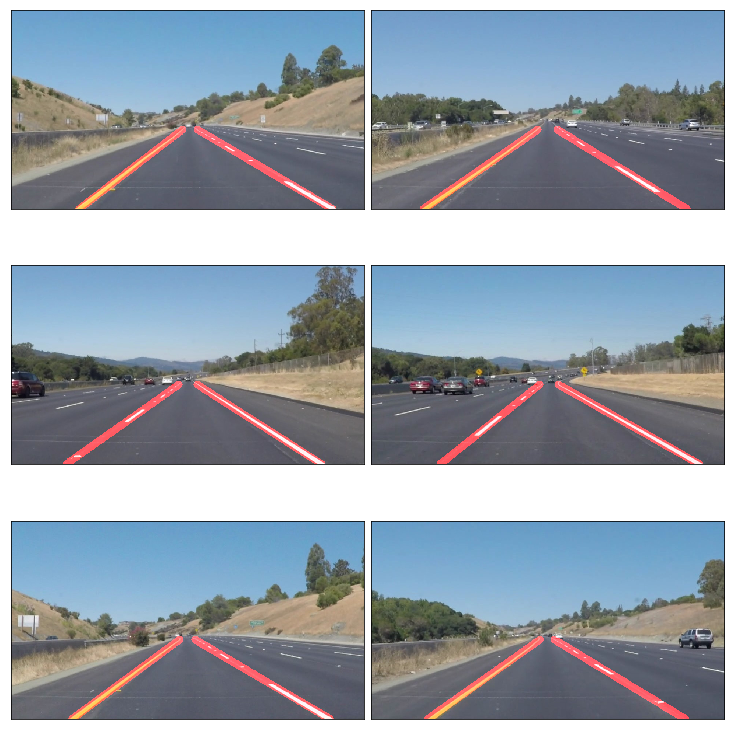

In [64]:
def average_slope_intercept(lines):
    left_lines = []    # (slope, intercept)
    left_weights = []  # (length,)
    right_lines = []   # (slope, intercept)
    right_weights = [] # (length,)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # ignore a vertical line
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
            if slope < 0:  # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

    # add more weight to longer lines
    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

    return left_lane, right_lane  # (slope, intercept), (slope, intercept)


def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None

    slope, intercept = line

    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))


def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)

    y1 = image.shape[0]  # bottom of the image
    y2 = y1 * 0.6        # top of roi

    left_line = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)

    return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # create image with lane lines, must have the same shape than the original image.
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    # combine the lane lines image with the orignal image
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)


lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

show_images(lane_images)


### 7. Step: Save output images
Finally we save the image copies with the lane line annotations in the `test_images_output` directory.

In [65]:
def save_image(image, filename):
    cv2.imwrite(os.path.join('test_images_output', filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR));

for image, path in zip(test_images, test_image_paths):
    save_image(image, os.path.basename(path))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

QUEUE_LENGTH = 50

left_lines = deque(maxlen=QUEUE_LENGTH)
right_lines = deque(maxlen=QUEUE_LENGTH)

def process_image(image):
    # lane line detection pipeline
    gray = convert_gray_scale(image)
    smooth_gray = apply_smoothing(gray)
    edges = detect_edges(smooth_gray)
    regions = select_region(edges)
    lines = hough_lines(regions)
    left_line, right_line = lane_lines(image, lines)

    def mean_line(line, lines):
        if line is not None:
            lines.append(line)

        if len(lines) > 0:
            line = np.mean(lines, axis=0, dtype=np.int32)
            line = tuple(map(tuple, line))
        return line

    left_line = mean_line(left_line, left_lines)
    right_line = mean_line(right_line, right_lines)

    return draw_lane_lines(image, (left_line, right_line))

def process_video(video_input, video_output):
    clip = VideoFileClip(video_input)
    processed = clip.fl_image(process_image)
    processed.write_videofile(video_output, audio=False)

Let's try image `solidWhiteRight.mp4` with the solid white lane on the right first ...

In [75]:
def get_input_path(path):
    return os.path.join('test_videos', path)

def get_output_path(path):
    return os.path.join('test_videos_output', path)

white_output = get_output_path('solidWhiteRight.mp4')
process_video(get_input_path('solidWhiteRight.mp4'), white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:15<00:00, 13.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



Result for `solidWhiteRight.mp4`

In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the `solidYellowLeft.mp4` with the solid yellow lane on the left.

In [73]:
yellow_output = get_output_path('solidYellowLeft.mp4')
process_video(get_input_path('solidYellowLeft.mp4'), yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:50<00:00, 13.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 



Result for `solidYellowLeft.mp4`

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [79]:
challenge_output = get_output_path('challenge.mp4')
process_video(get_input_path('challenge.mp4'), challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:35<00:00,  6.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



Result for `challenge.mp4`

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))